# Libraries

In [1]:
import time
start_time = time.time()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/CNN.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Bongard Testing.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
from os import path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import accuracy_score
import time
import natsort
from PIL import Image

# Functions:

#### 1) Function to plot bongard images

In [6]:
def load_and_resize_images(folder_path, target_size):
    image_paths = glob.glob(os.path.join(folder_path, '*.png'))
    image_paths = natsort.natsorted(image_paths)
    images = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img = img.resize(target_size)
            if img.mode == 'RGBA':
                img = img.convert('L')
            img_arr = np.array(img)
            if len(img_arr.shape) == 2:
                img_arr = img_arr[..., np.newaxis]
            images.append(img_arr)
    return np.array(images)

def plot_image_from_array(images_array, image_index, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(images_array[image_index, :, :, 0], cmap='gray', aspect='auto')
    plt.title(f"Image {image_index + 1}")
    plt.axis('off')
    plt.show()

folder_B_path = '/content/Bongard Testing/BP'
target_size = (330, 516)
images_array = load_and_resize_images(folder_B_path, target_size)

#### 2) Function to preprocess images

In [7]:
# Preprocessing:
def load_imgs(list_of_img_paths):
    alpaca_lst = []
    for imgs in list_of_img_paths:
        img=tf.keras.utils.load_img(
                            imgs,
                            color_mode = "grayscale",
                            target_size=None,
                            interpolation="nearest",
                            keep_aspect_ratio=False)

        input_arr = tf.keras.utils.img_to_array(img)

        inpt_img_arr = input_arr / 255.0
        alpaca_lst.append(inpt_img_arr)
    imgs_arr =np.array(alpaca_lst)
    return imgs_arr

#### 3) Function to plot any image with their labels

In [8]:
import matplotlib.pyplot as plt

def plot_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns for a 2x5 grid of subplots
        plt.imshow(images[i], cmap='gray')  # Display the image
        plt.title(f'Label: {labels[i]}')    # Set the title with the corresponding label
        plt.axis('off')                     # Turn off axis labels and ticks

    plt.tight_layout()
    plt.show()

#### 4) functions to create masked labels

In [9]:
# Generate masked labels for heads except selected head
def create_masked_labels(selected_head_name, excluded_head_names, labels):
    masked_labels = {}
    masked_labels[selected_head_name] = labels
    for head_name in excluded_head_names:
        masked_labels[head_name] = np.full_like(labels, -1)
    return masked_labels
def masked_label(selected_head_name,Ci_y_train):
    # Define the list of output head layer names
    output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

    # Exclude the selected head from generating masked labels
    excluded_head_names = [name for name in output_names if name != selected_head_name]

    # Generate masked labels for all excluded heads
    Ci_masked_labels = create_masked_labels(selected_head_name, excluded_head_names, Ci_y_train)
    return Ci_masked_labels

#### 5) Function to preprocess and split the data into training and testing

In [10]:
def data_load_split(Classifier_path,folder_A,folder_B):
    os.getcwd()
    dataset_path = os.getcwd()
    a = os.path.join('/content/CNN',Classifier_path)
    A = os.path.join(dataset_path, a)
    A_A = os.path.join(A, folder_A)
    A_B = os.path.join(A, folder_B)
    A_A = glob.glob(A_A +"/*.png")
    A_B = glob.glob(A_B +"/*.png")
    A_A_arr =load_imgs(A_A)
    A_B_arr =load_imgs(A_B)


    # Generate labels corresponding to above concept classes.
    A_A_labels =  np.zeros([len(A_A_arr), 1], dtype = int)  #labeled as 0
    A_B_labels =  np.ones([len(A_B_arr), 1], dtype = int) #labeled as 1

    Ci_X = np.concatenate((A_A_arr, A_B_arr), axis=0)
    Ci_y = np.concatenate((A_A_labels , A_B_labels), axis=0)

    # Split the data into training and testing sets
    Ci_X_train, Ci_X_test, Ci_y_train, Ci_y_test = train_test_split(Ci_X, Ci_y,
                                                                    test_size=0.2, random_state=42, shuffle=True)

    return Ci_X_train,Ci_X_test,Ci_y_train,Ci_y_test

#### Automate the code to load every classifier images and split.

In [11]:
# Path to the main folder
main_folder_path = "/content/CNN"

# Get the names of first-level subfolders in "A"
subfolder_names = [name for name in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, name))]
subfolder_names = sorted(subfolder_names)
start_time = time.time()
# Iterate through the first-level subfolders and call data_load_split
for i, subfolder_name in enumerate(subfolder_names):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)
    subsubfolder_names = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]

    if len(subsubfolder_names) == 2:
        print(f'classifier C{i}:', subfolder_name)
#         print(subsubfolder_names[0],subsubfolder_names[1])
        exec(f'C{i}_X_train, C{i}_X_test, C{i}_y_train, C{i}_y_test = data_load_split(subfolder_name,subsubfolder_names[0],subsubfolder_names[1])')
        print("Shape:")

        print(locals()[f'C{i}_X_train'].shape, locals()[f'C{i}_y_train'].shape,locals()[f'C{i}_X_test'].shape,
        locals()[f'C{i}_y_test'].shape)
        print('\n')
end_time = time.time()
Preprocess_Time = end_time - start_time
print("Time taken for Preprocess data:", Preprocess_Time, "seconds")

classifier C0: B) center  vs not incenter
Shape:
(3680, 100, 100, 1) (3680, 1) (920, 100, 100, 1) (920, 1)


classifier C1: C) Circle vs not circle
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C2: D) Closed figure vs Open figure
Shape:
(1232, 100, 100, 1) (1232, 1) (308, 100, 100, 1) (308, 1)


classifier C3: E) Co-linear vs Non-colinear
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C4: F) Concave vs Convex
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C5: G) Four sides vs not four side
Shape:
(5600, 100, 100, 1) (5600, 1) (1400, 100, 100, 1) (1400, 1)


classifier C6: H) Triangle vs not Triangle
Shape:
(5584, 100, 100, 1) (5584, 1) (1396, 100, 100, 1) (1396, 1)


classifier C7: I) Clockwise vs Anticlock wise
Shape:
(2400, 100, 100, 1) (2400, 1) (600, 100, 100, 1) (600, 1)


classifier C8: J) Left vs Right
Shape:
(2000, 100, 100, 1) (2000, 1) (500, 100, 100, 1) (500, 1)


classifier C9: K) 

# Multi-Head CNN

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


def Multi_head_CNN():

  # Input Shape
  input_shape = (100, 100, 1)
  input_layer = Input(shape=input_shape)

  # CNN common model:
  CNN_L1 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
  CNN_L2 = BatchNormalization()(CNN_L1)
  CNN_L3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L2)

  CNN_L4 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L3)
  CNN_L5 = BatchNormalization()(CNN_L4)
  CNN_L6 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L5)

  CNN_L7 = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L6)
  CNN_L8 = BatchNormalization()(CNN_L7)
  CNN_L9 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L8)

  CNN_L10 = Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L9)
  CNN_L11 = BatchNormalization()(CNN_L10)
  CNN_L12 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L11)

  CNN_L13 = Flatten()(CNN_L12)

  # Add more layers
  Common_Layer = Dense(128, activation='relu')(CNN_L13)
  Common_Layer = Dense(10, activation='relu')(Common_Layer)

  # Individual Head: Center vs not incenter
  center_vs_notincenter = Dense(1, activation='sigmoid', name='center_vs_notincenter')(Common_Layer)

  # Individual Head: Circle vs not circle
  circle_vs_notcircle = Dense(1, activation='sigmoid', name='circle_vs_notcircle')(Common_Layer)

  # Individual Head: Closed_vs_Open_figure
  Closed_vs_Open_figure = Dense(1, activation='sigmoid', name='Closed_vs_Open_figure')(Common_Layer)

  # Individual Head: Co-linear_vs_Non-colinear
  Colinear_vs_Noncolinear = Dense(1, activation='sigmoid', name='Colinear_vs_Noncolinear')(Common_Layer)

  # Individual Head: Concave_vs_Convex
  Concave_vs_Convex = Dense(1, activation='sigmoid', name='Concave_vs_Convex')(Common_Layer)


  Four_vs_notfour_side =Dense(1, activation='sigmoid', name='Four_vs_notfour_side')(Common_Layer)


  Triangle_vs_notTriangle =Dense(1, activation='sigmoid', name='Triangle_vs_notTriangle')(Common_Layer)


  Clockwise_vs_Anticlock_wise =  Dense(1, activation='sigmoid', name='Clockwise_vs_Anticlock_wise')(Common_Layer)


  Left_vs_Right =  Dense(1, activation='sigmoid', name='Left_vs_Right')(Common_Layer)


  Parallel_vs_perpendicular =  Dense(1, activation='sigmoid', name='Parallel_vs_perpendicular')(Common_Layer)


  Filled_vs_Unfilled =  Dense(1, activation='sigmoid', name='Filled_vs_Unfilled')(Common_Layer)


  Complete_vs_Incomplete =  Dense(1, activation='sigmoid', name='Complete_vs_Incomplete')(Common_Layer)


  Intersect_vs_NonIntersect =  Dense(1, activation='sigmoid', name='Intersect_vs_NonIntersect')(Common_Layer)


  M_cluster_vs_N_clusters =  Dense(1, activation='sigmoid', name='M_cluster_vs_N_clusters')(Common_Layer)


  Above_vs_Below =  Dense(1, activation='sigmoid', name='Above_vs_Below')(Common_Layer)


  Same_vs_Not_Same =  Dense(1, activation='sigmoid', name='Same_vs_Not_Same')(Common_Layer)

  Size_big_vs_Small =  Dense(1, activation='sigmoid', name='Size_big_vs_Small')(Common_Layer)

  Symmetery_vs_Non_symmetery = Dense(1, activation='sigmoid', name='Symmetery_vs_Non_symmetery')(Common_Layer)

  Horizontal_vs_Vertical = Dense(1, activation='sigmoid', name='Horizontal_vs_Vertical')(Common_Layer)

  Empty_vs_Non_Empty = Dense(1, activation='sigmoid', name='Empty_vs_Non_Empty')(Common_Layer)


  # Create the model
  model = Model(inputs=input_layer, outputs=[
                                            center_vs_notincenter,
                                            circle_vs_notcircle,
                                            Closed_vs_Open_figure,
                                            Colinear_vs_Noncolinear,
                                            Concave_vs_Convex,
                                            Four_vs_notfour_side,
                                            Triangle_vs_notTriangle,
                                            Clockwise_vs_Anticlock_wise,
                                            Left_vs_Right,
                                            Parallel_vs_perpendicular,
                                            Filled_vs_Unfilled,
                                            Complete_vs_Incomplete,
                                            Intersect_vs_NonIntersect,
                                            M_cluster_vs_N_clusters,
                                            Above_vs_Below,
                                            Same_vs_Not_Same,
                                            Size_big_vs_Small,
                                            Symmetery_vs_Non_symmetery,
                                            Horizontal_vs_Vertical,
                                            Empty_vs_Non_Empty
                                            ])

  # Compile the model with appropriate loss functions for each head
  model.compile(optimizer='adam',


                loss={
                'center_vs_notincenter': 'binary_crossentropy',
                'circle_vs_notcircle': 'binary_crossentropy',
                'Closed_vs_Open_figure': 'binary_crossentropy',
                'Colinear_vs_Noncolinear': 'binary_crossentropy',
                'Concave_vs_Convex': 'binary_crossentropy',
                'Four_vs_notfour_side': 'binary_crossentropy',
                'Triangle_vs_notTriangle': 'binary_crossentropy',
                'Clockwise_vs_Anticlock_wise': 'binary_crossentropy',
                'Left_vs_Right': 'binary_crossentropy',
                'Parallel_vs_perpendicular': 'binary_crossentropy',
                'Filled_vs_Unfilled': 'binary_crossentropy',
                'Complete_vs_Incomplete': 'binary_crossentropy',
                'Intersect_vs_NonIntersect': 'binary_crossentropy',
                'M_cluster_vs_N_clusters': 'binary_crossentropy',
                'Above_vs_Below': 'binary_crossentropy',
                'Same_vs_Not_Same': 'binary_crossentropy',
                'Size_big_vs_Small':'binary_crossentropy',
                'Symmetery_vs_Non_symmetery':'binary_crossentropy',
                'Horizontal_vs_Vertical':'binary_crossentropy',
                'Empty_vs_Non_Empty':'binary_crossentropy',
                })
  return model

### Training Models

In [13]:
Final_test_accuracies = []

#### Define traning and label data

In [14]:
X = [C0_X_train, C1_X_train,C2_X_train,C3_X_train, C4_X_train,C5_X_train,C6_X_train, C7_X_train,C8_X_train,C9_X_train,
     C10_X_train,C11_X_train,C12_X_train, C13_X_train,C14_X_train,C15_X_train,C16_X_train,C17_X_train,C18_X_train,
     C19_X_train]

Y=  [C0_y_train,C1_y_train,C2_y_train,C3_y_train,C4_y_train,C5_y_train,C6_y_train,C7_y_train,C8_y_train,C9_y_train,
C10_y_train,C11_y_train,C12_y_train,C13_y_train,C14_y_train,C15_y_train,C16_y_train,C17_y_train,C18_y_train,C19_y_train,]

output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

In [15]:
Model_0_loss=[]
Model_1_loss=[]
Model_2_loss=[]
Model_3_loss=[]
Model_4_loss=[]
Model_5_loss=[]
Model_6_loss=[]
Model_7_loss=[]
Model_8_loss=[]
Model_9_loss=[]
Model_10_loss=[]
Model_11_loss=[]
Model_12_loss=[]
Model_13_loss=[]
Model_14_loss=[]
Model_15_loss=[]
Model_16_loss=[]
Model_17_loss=[]
Model_18_loss=[]
Model_19_loss=[]

#### Head 0 checking

In [16]:
# Creating new model for cold start.
model_0 = Multi_head_CNN()
# Creating 10 epochs, each epoch train all heads at a time.
epochs=10
# Number of heads to be traine
num_heads=1

for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_0.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_0_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 14s 7ms/step - loss: 0.3564 - center_vs_notincenter_loss: 0.3564 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.2487 - center_vs_notincenter_loss: 0.2487 

#### Cheking accuracy on classifiers

In [17]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_0.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

Temp_var=check_accuracy(C0_X_test,C0_y_test,0)
# Append this accuracy into Final_test_accuracies list
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)


29/29 [==============================] - 0s 5ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.9358695652173913


### Head 0 and 1 checking

In [18]:
# Creating new model for cold start.
model_1 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=2

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_1.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_1_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3625 - center_vs_notincenter_loss: 0.3625 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3555 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3555 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.2990 - center_vs_notincenter_loss: 0.2990 - c

In [19]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_1.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.7195652173913043
13/13 [==============================] - 0s 7ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.975
Average Test accuracies of all heads:  0.85
Final_test_accuracies:  [0.94, 0.85]



### Head 0, 1 and 2 checking

In [20]:
# Creating new model for cold start.
model_2 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=3

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_2.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_2_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3716 - center_vs_notincenter_loss: 0.3716 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2468 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2468 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 10ms/step - loss: 0.4735 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4735 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.3526 - center_vs_notincenter_loss: 0.3526 - 

In [21]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_2.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.8456521739130435
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.975
10/10 [==============================] - 0s 9ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.9188311688311688
Average Test accuracies of all heads:  0.91
Final_test_accuracies:  [0.94, 0.85, 0.91]



### Head 0, 1, 2 and 3 checking

In [22]:
# Creating new model for cold start.
model_3 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=4

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_3.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_3_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3337 - center_vs_notincenter_loss: 0.3337 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3130 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3130 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.5514 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5514 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6935 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.4687 - center_vs_notincenter_loss: 0.4687 - c

In [23]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_3.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.7239130434782609
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.98
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.9090909090909091
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.51
Average Test accuracies of all heads:  0.78
Final_test_accuracies:  [0.94, 0.85, 0.91, 0.78]



### Head 0, 1, 2, 3 and 4 checking

In [24]:
# Creating new model for cold start.
model_4 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=5

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_4.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_4_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3501 - center_vs_notincenter_loss: 0.3501 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2117 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2117 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.5114 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5114 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 2s 7ms/step - loss: 0.6786 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6786 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7714 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7714 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5372 - center_vs_notincenter_loss: 0.5372 - c

In [25]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_4.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5108695652173914
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.4375
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.7532467532467533
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.5075
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.525
Average Test accuracies of all heads:  0.55
Final_test_accuracies:  [0.94, 0.85, 0.91, 0.78, 0.55]



### Head 0, 1, 2, 3, 4, and 5 checking

In [26]:
# Creating new model for cold start.
model_5 = Multi_head_CNN()
start_time = time.time()

# Define epochs and number of heads to be train
epochs=10
num_heads=6

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_5.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_5_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3604 - center_vs_notincenter_loss: 0.3604 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3204 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3204 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.6278 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.6278 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.8385 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.8385 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7063 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7063 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5429 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5429 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5414 - center_vs_notincenter_loss: 0.5414 -

In [27]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_5.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 4ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.533695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.97
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.4805194805194805
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.495
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.8621428571428571
Average Test accuracies of all heads:  0.64
Final_test_accuracies:  [0.94, 0.85, 0.91, 0.78, 0.55, 0.64]



### Head 0, 1, 2, 3, 4, 5, 6 checking

In [28]:
# Creating new model for cold start.
model_6 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=7

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_6.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_6_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.4172 - center_vs_notincenter_loss: 0.4172 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2441 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2441 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.5792 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5792 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7252 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7252 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.6977 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.6977 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 3s 7ms/step - loss: 0.5382 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5382 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5271 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5271 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5304 - center_vs_notincenter_loss: 0.5304 -

In [29]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_6.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5173913043478261
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.9675
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.8214285714285714
13/13 [==============================] - 0s 4ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.8071428571428572
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.7005730659025788
Average Test accuracies of all heads:  0.69
Final_test_accuracies:  [0.94, 0.85, 0.91, 0.78, 0.55, 0.64, 0.69]



### Head 0, 1, 2, 3, 4, 5, 6 ,7 checking

In [30]:
# Creating new model for cold start.
model_7 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=8

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_7.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_7_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3498 - center_vs_notincenter_loss: 0.3498 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2548 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2548 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.5355 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5355 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6943 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6943 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7279 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7279 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5181 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5181 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5456 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5456 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7119 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7119 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.6137 - center_vs_notincenter_loss: 0.6137 - c

In [31]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_7.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C0: 0.483695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C1: 0.5025
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C2: 0.5064935064935064
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C4: 0.4975
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.4928571428571429
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.4792263610315186
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.4783333333

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 checking

In [32]:
# Creating new model for cold start.
model_8 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=9

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_8.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_8_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3712 - center_vs_notincenter_loss: 0.3712 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2427 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2427 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4294 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4294 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.5560 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.5560 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7151 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7151 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 3s 7ms/step - loss: 0.4451 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.4451 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5228 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5228 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7000 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7000 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 8ms/step - loss: 0.6616 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6616 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5571 - center_vs_notincenter_loss: 0.5571 - c

In [33]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_8.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5576086956521739
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.75
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.7175324675324676
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.7925
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.5275
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.7064285714285714
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.6934097421203438
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9  checking

In [34]:
# Creating new model for cold start.
model_9 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=10

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_9.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_9_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3307 - center_vs_notincenter_loss: 0.3307 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2704 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2704 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4836 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4836 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.8201 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.8201 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7021 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7021 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5241 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5241 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.6747 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.6747 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.6977 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.6977 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 8ms/step - loss: 0.6860 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6860 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 8ms/step - loss: 0.6905 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6905 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.4912 - center_vs_notincenter_loss: 0.4912 - c

In [35]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_9.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.6326086956521739
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.595
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.5876623376623377
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.515
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.4625
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.66
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.6368194842406877
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0.51
16/16 [===

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10  checking

In [36]:
# Creating new model for cold start.
model_10 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=11

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_10.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_10_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3489 - center_vs_notincenter_loss: 0.3489 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2763 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2763 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4754 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4754 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7381 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7381 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7201 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7201 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5293 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5293 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 3s 7ms/step - loss: 0.5037 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5037 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7034 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7034 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 7ms/step - loss: 0.7084 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.7084 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6950 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6950 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6496 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6496 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5967 - center_vs_notincenter_loss: 0.5967 - c

In [37]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_10.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.6478260869565218
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.5375
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.4025974025974026
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C4: 0.4975
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.7621428571428571
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.660458452722063
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C7: 0.5216

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 checking

In [38]:
# Creating new model for cold start.
model_11 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=12

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_11.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_11_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3884 - center_vs_notincenter_loss: 0.3884 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3024 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3024 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.8366 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.8366 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7118 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7118 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.6963 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.6963 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5868 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5868 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5301 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5301 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7133 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7133 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 8ms/step - loss: 0.6913 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6913 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6973 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6973 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6948 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6948 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6576 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6576 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5499 - center_vs_notincenter_loss: 0.5499 -

In [39]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_11.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.49782608695652175
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.8125
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.4025974025974026
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.5025
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C4: 0.4975
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.7571428571428571
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.669054441260745
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.4

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12 checking

In [40]:
# Creating new model for cold start.
model_12 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=13

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_12.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_12_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3347 - center_vs_notincenter_loss: 0.3347 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3011 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3011 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 7ms/step - loss: 0.4656 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4656 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6968 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6968 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.6981 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.6981 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5058 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5058 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.6148 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.6148 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7128 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7128 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.6858 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6858 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6943 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6943 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6805 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6805 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6090 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6090 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 8ms/step - loss: 0.6967 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6967 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.6785 - center_vs_notincenter_loss: 0.6785 -

In [41]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_12.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.525
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.6575
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C2: 0.4935064935064935
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.4525
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.52
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.6335714285714286
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.5408309455587392
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0.50333333333333

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13 checking

In [42]:
# Creating new model for cold start.
model_13 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=14

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_13.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_13_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3839 - center_vs_notincenter_loss: 0.3839 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.4677 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.4677 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4328 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4328 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7931 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7931 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7099 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7099 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5010 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5010 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5692 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5692 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.6975 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.6975 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.6788 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6788 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6988 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6988 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6256 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6256 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6306 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6306 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 7ms/step - loss: 0.4783 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.4783 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.7008 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.7008 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5501 - center_vs_notincenter_loss: 0.5501 - c

In [43]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_13.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5597826086956522
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.6125
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.538961038961039
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.505
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.5228571428571429
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.4828080229226361
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 checking

In [44]:
# Creating new model for cold start.
model_14 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=15

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_14.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_14_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3841 - center_vs_notincenter_loss: 0.3841 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2817 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2817 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 7ms/step - loss: 0.5914 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5914 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7222 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7222 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.8703 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.8703 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.4987 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.4987 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5771 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5771 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 2s 7ms/step - loss: 0.7055 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7055 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.7025 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.7025 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6933 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 2s 7ms/step - loss: 0.7004 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.7004 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6938 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6938 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 7ms/step - loss: 0.6938 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6938 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.6934 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6935 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.6935 - c

In [45]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_14.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C0: 0.483695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C1: 0.4975
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C2: 0.4935064935064935
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C4: 0.4975
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C5: 0.49214285714285716
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C6: 0.4785100286532951
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.4783333333333

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 , 15 checking

In [46]:
# Creating new model for cold start.
model_15 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=16

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_15.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_15_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3815 - center_vs_notincenter_loss: 0.3815 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3385 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3385 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4985 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4985 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6991 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6991 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 8ms/step - loss: 0.6966 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.6966 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5512 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5512 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5307 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5307 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.6980 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.6980 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.6864 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6864 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6937 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6937 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6942 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6942 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6787 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6787 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6934 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.6935 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6934 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 15


80/80 [==============================] - 2s 7ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6933 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5870 - center_vs_notincenter_loss: 0.5870 - c

In [47]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_15.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C0: 0.483695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C1: 0.4975
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C2: 0.5064935064935064
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C4: 0.4975
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C5: 0.5078571428571429
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C6: 0.5214899713467048
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.47833333333333

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 , 15, 16 checking

In [48]:
# Creating new model for cold start.
model_16 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=17

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_16.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_16_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3640 - center_vs_notincenter_loss: 0.3640 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2648 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2648 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.5284 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.5284 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.5859 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.5859 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7490 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7490 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5475 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5475 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5870 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5870 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.7369 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7369 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.6887 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6887 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6934 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6934 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6442 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6442 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 7ms/step - loss: 0.6945 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6945 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.6925 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.6925 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6988 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6988 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 15


80/80 [==============================] - 3s 7ms/step - loss: 0.6931 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6931 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 16


50/50 [==============================] - 1s 8ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.6933 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.6435 - center_vs_notincenter_loss: 0.6435 - c

In [49]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_16.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5608695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.6125
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.5454545454545454
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.44
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.6678571428571428
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.5888252148997135
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 , 15, 16 , 17 checking

In [50]:
# Creating new model for cold start.
model_17 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=18

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_17.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_17_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3598 - center_vs_notincenter_loss: 0.3598 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2913 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2913 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 7ms/step - loss: 0.6173 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.6173 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6035 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6035 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7155 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7155 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5361 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5361 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.6016 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.6016 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.6983 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.6983 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 8ms/step - loss: 0.6872 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6872 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6949 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6949 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6891 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6891 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6739 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6739 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 8ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6933 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.6934 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6933 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 15


80/80 [==============================] - 2s 7ms/step - loss: 0.6934 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6934 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 16


50/50 [==============================] - 1s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.6935 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 17


137/137 [==============================] - 2s 8ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.6933 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.6155 - center_vs_notincenter_loss: 0.6155 -

In [51]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_17.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.5554347826086956
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.5
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.4967532467532468
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C3: 0.5025
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.49142857142857144
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.4777936962750716
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.47833

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 , 15, 16 , 17 , 18 checking

In [52]:
# Creating new model for cold start.
model_18 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=19

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_18.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_18_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 5s 7ms/step - loss: 0.3658 - center_vs_notincenter_loss: 0.3658 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3610 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3610 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.3697 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.3697 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.7006 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.7006 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7259 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7259 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5388 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5388 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 8ms/step - loss: 0.5129 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5129 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.6991 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.6991 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 1s 7ms/step - loss: 0.6871 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6871 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 7ms/step - loss: 0.6937 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6937 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6424 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6424 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6411 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6411 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 8ms/step - loss: 0.5252 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.5252 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.7961 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.7961 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6949 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6949 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 15


80/80 [==============================] - 2s 7ms/step - loss: 0.6936 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6936 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 16


50/50 [==============================] - 1s 7ms/step - loss: 0.6933 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.6933 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 17


137/137 [==============================] - 2s 7ms/step - loss: 0.6530 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.6530 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 18


50/50 [==============================] - 1s 7ms/step - loss: 0.4594 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.4594 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5831 - center_vs_notincenter_loss: 0.5831 - c

In [53]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_18.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C0: 0.483695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C1: 0.4975
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C2: 0.4935064935064935
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.495
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C5: 0.49214285714285716
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C6: 0.4785100286532951
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.478333333333

### Head 0, 1, 2, 3, 4, 5, 6 ,7 8 , 9, 10 , 11 , 12, 13, 14 , 15, 16 , 17 , 18, 19  checking

In [54]:
# Creating new model for cold start.
model_19 = Multi_head_CNN()

# Define epochs and number of heads to be train
epochs=10
num_heads=20

Test_accuracies=[]
for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')
    Model_history=model_19.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
    Training_loss=Model_history.history['loss']
    Model_19_loss.append(Training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 6s 7ms/step - loss: 0.3622 - center_vs_notincenter_loss: 0.3622 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.2412 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2412 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 2


39/39 [==============================] - 1s 8ms/step - loss: 0.4594 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4594 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 3


50/50 [==============================] - 1s 7ms/step - loss: 0.6182 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6182 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 4


50/50 [==============================] - 1s 7ms/step - loss: 0.7784 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7784 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 5


175/175 [==============================] - 2s 7ms/step - loss: 0.5170 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5170 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5642 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5642 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 7


75/75 [==============================] - 1s 7ms/step - loss: 0.7190 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7190 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 8


63/63 [==============================] - 2s 7ms/step - loss: 0.6850 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6850 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 9


25/25 [==============================] - 1s 8ms/step - loss: 0.7010 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.7010 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 10


55/55 [==============================] - 1s 7ms/step - loss: 0.6949 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.6949 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.6525 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6525 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 12


112/112 [==============================] - 2s 7ms/step - loss: 0.5465 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.5465 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 13


50/50 [==============================] - 1s 7ms/step - loss: 0.7240 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.7240 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 14


60/60 [==============================] - 1s 7ms/step - loss: 0.6971 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.6971 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 15


80/80 [==============================] - 2s 7ms/step - loss: 0.6945 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6945 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 16


50/50 [==============================] - 1s 7ms/step - loss: 0.5784 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.5784 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 17


137/137 [==============================] - 2s 7ms/step - loss: 0.6519 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.6519 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 18


50/50 [==============================] - 1s 7ms/step - loss: 0.3988 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.3988 - Empty_vs_Non_Empty_loss: 0.0000e+00

epoch 0 Head 19


25/25 [==============================] - 1s 7ms/step - loss: 0.2708 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.2708

epoch 1 Head 0
115/115 [==============================] - 1s 7ms/step - loss: 0.5508 - center_vs_notincenter_loss: 0.5508 - c

In [55]:
def check_accuracy(X_test,Y_test,i):
  predictions = model_19.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
# Append each head accuracy into Test_accuracies list
  Test_accuracies.append(Temp_var)

# Calculate the average accuracies of all Sequential subset heads.
Average_accuracies = sum(Test_accuracies)/num_heads
# Round off upto two digits
Rounded_average_accuracies = round(Average_accuracies, 2)
print("Average Test accuracies of all heads: ",Rounded_average_accuracies)
# Now storing average accuracies of all Sequential subset heads into Final_test_accuracies list.
Final_test_accuracies.append(Rounded_average_accuracies)
print("Final_test_accuracies: ",Final_test_accuracies)
print()

29/29 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C0: 0.483695652173913
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C1: 0.5025
10/10 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C2: 0.5064935064935064
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0]
Accuracy for Classifier C3: 0.4975
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C4: 0.5025
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C5: 0.49214285714285716
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C6: 0.4785100286532951
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C7: 0.4783333333333

In [56]:
Final_test_accuracies

[0.94,
 0.85,
 0.91,
 0.78,
 0.55,
 0.64,
 0.69,
 0.49,
 0.69,
 0.59,
 0.58,
 0.58,
 0.56,
 0.57,
 0.5,
 0.5,
 0.54,
 0.51,
 0.49,
 0.5]

In [57]:
Model_0_loss_avg=sum(Model_0_loss)/len(Model_0_loss)
Model_1_loss_avg=sum(Model_1_loss)/len(Model_1_loss)
Model_2_loss_avg=sum(Model_2_loss)/len(Model_2_loss)
Model_3_loss_avg=sum(Model_3_loss)/len(Model_3_loss)
Model_4_loss_avg=sum(Model_4_loss)/len(Model_4_loss)
Model_5_loss_avg=sum(Model_5_loss)/len(Model_5_loss)
Model_6_loss_avg=sum(Model_6_loss)/len(Model_6_loss)
Model_7_loss_avg=sum(Model_7_loss)/len(Model_7_loss)
Model_8_loss_avg=sum(Model_8_loss)/len(Model_8_loss)
Model_9_loss_avg=sum(Model_9_loss)/len(Model_9_loss)
Model_10_loss_avg=sum(Model_10_loss)/len(Model_10_loss)
Model_11_loss_avg=sum(Model_11_loss)/len(Model_11_loss)
Model_12_loss_avg=sum(Model_12_loss)/len(Model_12_loss)
Model_13_loss_avg=sum(Model_13_loss)/len(Model_13_loss)
Model_14_loss_avg=sum(Model_14_loss)/len(Model_14_loss)
Model_15_loss_avg=sum(Model_15_loss)/len(Model_15_loss)
Model_16_loss_avg=sum(Model_16_loss)/len(Model_16_loss)
Model_17_loss_avg=sum(Model_17_loss)/len(Model_17_loss)
Model_18_loss_avg=sum(Model_18_loss)/len(Model_18_loss)
Model_19_loss_avg=sum(Model_19_loss)/len(Model_19_loss)

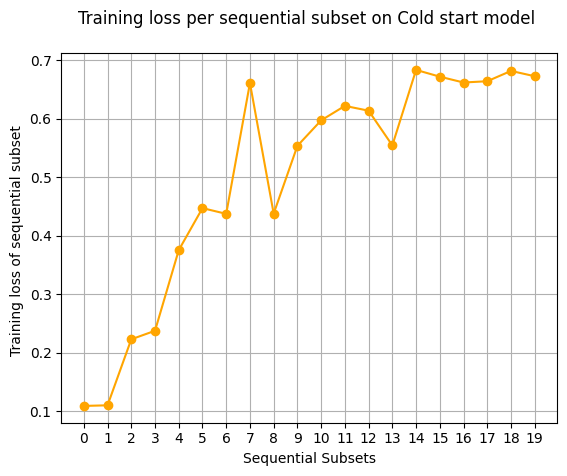

In [58]:
Sequential_subsets = range(0,20)

Model_loss=[Model_0_loss_avg,Model_1_loss_avg,Model_2_loss_avg,Model_3_loss_avg,Model_4_loss_avg,Model_5_loss_avg,
            Model_6_loss_avg,Model_7_loss_avg,Model_8_loss_avg,Model_9_loss_avg,Model_10_loss_avg,Model_11_loss_avg,
            Model_12_loss_avg,Model_13_loss_avg,Model_14_loss_avg,Model_15_loss_avg,Model_16_loss_avg,Model_17_loss_avg,
           Model_18_loss_avg,Model_19_loss_avg]

# Create the plot
plt.plot(Sequential_subsets, Model_loss, marker='o',color='orange')

# Add labels and title
plt.xlabel('Sequential Subsets')
plt.ylabel('Training loss of sequential subset ')
plt.title('Training loss per sequential subset on Cold start model \n')

# Display the plot
plt.grid(True)
plt.xticks(Sequential_subsets)
plt.show()

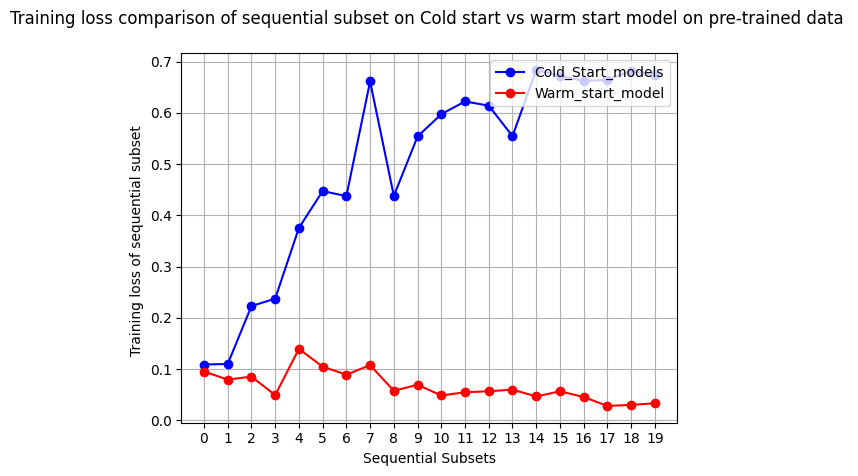

In [59]:
Sequential_subsets = range(0,20)

Model_loss_cold_start=[Model_0_loss_avg,Model_1_loss_avg,Model_2_loss_avg,Model_3_loss_avg,Model_4_loss_avg,Model_5_loss_avg,
            Model_6_loss_avg,Model_7_loss_avg,Model_8_loss_avg,Model_9_loss_avg,Model_10_loss_avg,Model_11_loss_avg,
            Model_12_loss_avg,Model_13_loss_avg,Model_14_loss_avg,Model_15_loss_avg,Model_16_loss_avg,Model_17_loss_avg,
           Model_18_loss_avg,Model_19_loss_avg]

Sequential_subsets_loss_warm_start = [0.09524372071027756,0.07938721782993526,0.08534498922526837,0.04912662351489416,0.13941173578961752,0.10461012168088928,0.08908867368341557,
                                      0.10764271031948738,0.0576463025658288,0.06934022277768236,0.04844318904321302,0.05476453071848179,0.05668108216486871,0.05988530912519699,0.046576115804103514,
                                      0.056595150349312465,0.04543263210704454,0.028075862596354757,0.030148724960101965,0.033239566161937545]

# Create the plot
plt.plot(Sequential_subsets, Model_loss, marker='o',color='blue')
plt.plot(Sequential_subsets, Sequential_subsets_loss_warm_start, marker='o',color='red')

# Add labels and title
plt.xlabel('Sequential Subsets')
plt.ylabel('Training loss of sequential subset ')
plt.title('Training loss comparison of sequential subset on Cold start vs warm start model on pre-trained data \n')

plt.legend(labels=['Cold_Start_models', 'Warm_start_model'], loc='upper right')

# Display the plot
plt.grid(True)
plt.xticks(Sequential_subsets)
plt.show()

## Here sequential subsets 0 means: Concept 0
## Subsets 1 means: Concept 0 and concept 1
## Subsets 2 means: Concept 0 , concept 1, and concept 2
## and so on

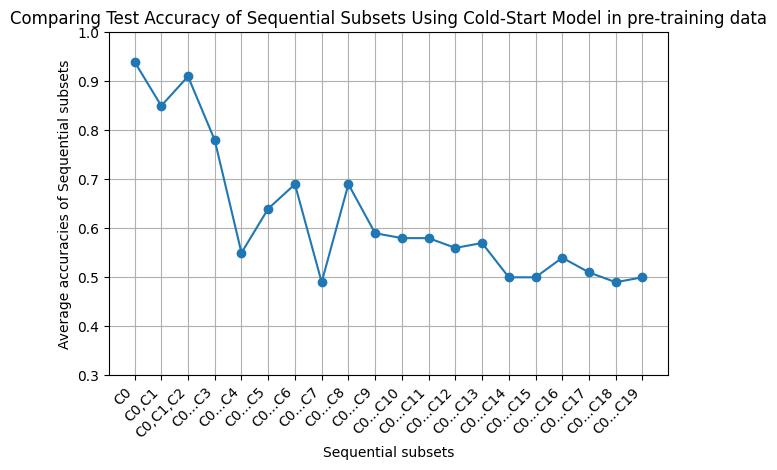

In [60]:
Sequential_subsets = ['C0', 'C0,C1', 'C0,C1,C2', 'C0...C3', 'C0...C4', 'C0...C5', 'C0...C6', 'C0...C7', 'C0...C8', 'C0...C9', 'C0...C10', 'C0...C11', 'C0...C12', 'C0...C13', 'C0...C14',
                      'C0...C15', 'C0...C16', 'C0...C17', 'C0...C18', 'C0...C19']

# Create the plot
plt.plot(Sequential_subsets, Final_test_accuracies, marker='o')

# Add labels and title
plt.xlabel('Sequential subsets')
plt.ylabel('Average accuracies of Sequential subsets')
plt.title('Comparing Test Accuracy of Sequential Subsets Using Cold-Start Model in pre-training data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.ylim(0.3, 1)
# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()


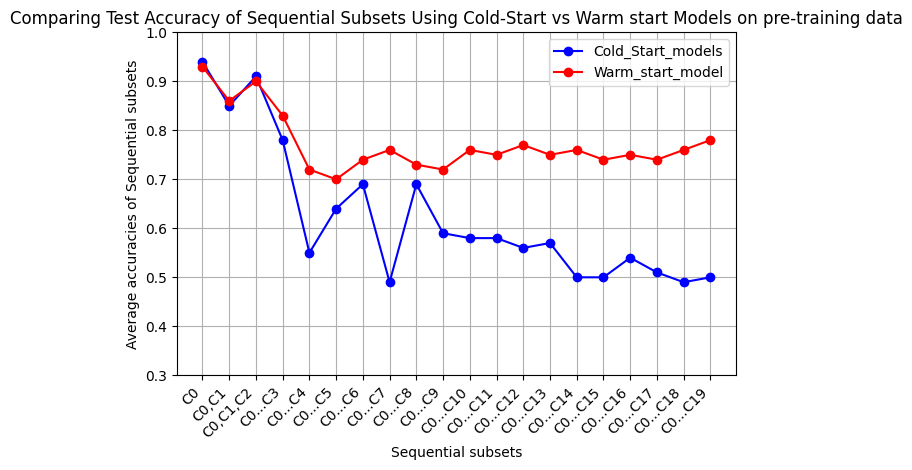

In [62]:
Sequential_subsets = ['C0', 'C0,C1', 'C0,C1,C2', 'C0...C3', 'C0...C4', 'C0...C5', 'C0...C6', 'C0...C7', 'C0...C8', 'C0...C9', 'C0...C10', 'C0...C11', 'C0...C12', 'C0...C13', 'C0...C14',
                      'C0...C15', 'C0...C16', 'C0...C17', 'C0...C18', 'C0...C19']

# Accuracy of Sequential Subsets Using Cold-Start Model represented by Blue line
plt.plot(Sequential_subsets, Final_test_accuracies, marker='o',color='blue')

# Accuracy of Sequential Subsets Using Warm-Start Model represented by Red line
Final_test_accuracies_warm_start_model = [0.93,0.86,0.90,0.83,0.72,0.7,0.74,0.76,0.73,0.72,0.76,0.75,0.77,0.75,0.76,0.74,0.75,0.74,0.76,0.78]

plt.plot(Sequential_subsets, Final_test_accuracies_warm_start_model, marker='o', color='red')  # Red line

# Add labels and title
plt.xlabel('Sequential subsets')
plt.ylabel('Average accuracies of Sequential subsets')
plt.title('Comparing Test Accuracy of Sequential Subsets Using Cold-Start vs Warm start Models on pre-training data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the legend
plt.legend(labels=['Cold_Start_models', 'Warm_start_model'], loc='upper right')

plt.ylim(0.3, 1)
# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()


In [63]:
end_time = time.time()
final_time = end_time - start_time
print()
print("Total Time to be taked for this experiment:", final_time, "seconds")
print()


Total Time to be taked for this experiment: 1908.3453152179718 seconds

